In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

In [2]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd

torch.set_default_dtype(torch.float32)

In [3]:
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

## Declare classes

In [4]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[10]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]

    def forward(self, data):
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out
    
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

In [76]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256, 128], test_nodes=100):
        super().__init__()
        self.device = "cuda"
        
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.hidden2 = torch.nn.Linear(layers[1], layers[2])
        self.out = torch.nn.Linear(layers[2], self.out_size)
        
        self.dropout = torch.nn.Dropout()
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        
    def to(self, device):
        super().to(device)
        self.device = device
        self.test_mask = self._create_mask(self.test_nodes)
        return self
        
    def forward(self, data, mask=None):
        """ Get a hypernet prediction.
        
        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)

            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(data)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i].to(torch.bool)]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask

            nets = []
            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(mask)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[:, mask[i].to(torch.bool)]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

#     def forward(self, data, mask=None):
#         if mask is None:
#             mask = np.random.choice(len(template), self.mask_size, False)
#             tmp = self.template.copy()
#             tmp[mask] = 1
#             mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        
#         weights = self.craft_network(mask)
#         nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = data[:, mask.to(torch.bool)]
#         return nn(masked_data)
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden2(out)
        out = self.relu(out)
        
        out = self.out(out)
        return out

In [77]:
hypernet = Hypernetwork(mask_size=20, node_hidden_size=10).to("cuda")

In [78]:
hypernet.eval()
# print(hypernet(inputs).shape)
# print(hypernet.out_size)

Hypernetwork(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=320, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

## Load data

In [11]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [12]:
indices = torch.arange(60000)
trainset = data_utils.Subset(trainset, indices)

In [13]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, masks, mask_size):
        inputs = dataset[0][0].shape[0]
        self.mask_size = mask_size
        self.dataset = dataset
        self.template = np.zeros(inputs)
        self.masks = self._create_mask(masks)
        self.masks_indices = np.random.choice(np.arange(masks), len(dataset))
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32)
        return mask
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        mask = self.masks[self.masks_indices[idx]]
        return image, label, mask
    
masked_trainset = MaskedDataset(trainset, 20, 500)
masked_testset = MaskedDataset(testset, 20, 500)

In [14]:
batch_size = 32
test_batch_size = 1000

# trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=1)
# testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
#                                          shuffle=False, num_workers=1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

## Craft model

In [16]:
criterion = torch.nn.CrossEntropyLoss()

## Fixed mask benchmark

In [47]:
def train_preset_mask(hypernet, optimizer, trainloader, size):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
    experiment.add_tag("fixed_mask")
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", size)

    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs, mask.unsqueeze(0).repeat(len(inputs), 1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        for i, data in enumerate(testloader):
            images, labels = data
            denom += len(labels)
            images = images.cuda()
            labels = labels.cuda()
            outputs = hypernet(images, mask.unsqueeze(0).repeat(len(images), 1))
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        experiment.log_metric("test_accuracy", correct/denom*100, step=epoch)        

In [117]:
def get_dataset(size=60000, masked=False, mask_no=200, mask_size=700, shared_mask=False):
    trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
    testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)
    if masked:
        trainset = MaskedDataset(trainset, mask_no, mask_size)
        testset = MaskedDataset(testset, mask_no, mask_size)
        if shared_mask:
            testset.masks = trainset.masks
        
    indices = torch.arange(size)
    trainset = data_utils.Subset(trainset, indices)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)
    return trainloader, testloader

In [59]:
input_size = 784
mask_size = 700
nodes = 50

np.random.seed(42)
template = np.zeros(input_size)
mask_idx = np.random.choice(len(template), mask_size, False)
template[mask_idx] = 1
mask = torch.from_numpy(template).to(torch.float32).cuda()

In [50]:
epochs = 5

for size in [60000, 6000, 1000, 500, 100]:
    criterion = torch.nn.CrossEntropyLoss()
    hypernet = Hypernetwork(mask_size=mask_size, test_nodes=50, node_hidden_size=100).cuda()
    hypernet = hypernet.train()
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
    
    trainloader, testloader = get_dataset(size)
    
    train_preset_mask(hypernet, optimizer, trainloader, size)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/7eb1d54de7d948e8a7b46f85d12e7e36
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [25]     : (0.07219686359167099, 4.225034713745117)
COMET INFO:     test_accuracy : 90.44
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     test_nodes    : 50
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (102.01 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     so

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

## Dense network benchmark

In [135]:
def train_regular(network, optimizer, trainloader, size):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
    experiment.add_tag("dense-net")
    experiment.log_parameter("mask_size", 700)
    experiment.log_parameter("training_size", size)

    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        for i, data in enumerate(testloader):
            images, labels = data
            denom += len(labels)
            images = images.cuda()
            labels = labels.cuda()
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        experiment.log_metric("test_accuracy", correct/denom*100, step=epoch)     
    experiment.end()
    return correct/denom*100, test_loss[-1]

In [137]:
epochs = 5

results = defaultdict(list)
for i in range(10):
    for size in [60000, 6000, 1000, 500, 100]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = SimpleNetwork(784).cuda()
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size)

        results[size].append(train_regular(hypernet, optimizer, trainloader, size))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/b89fb46a7ccd47b48cdfea05430c08ca

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.78it/s]


Test acc: 94.52000000000001, loss: 0.19555341685190797


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 176.06it/s]


Test acc: 95.99, loss: 0.13775929298180228


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.32it/s]


Test acc: 96.38, loss: 0.11276267482660329


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.55it/s]


Test acc: 97.13000000000001, loss: 0.09763709428714207


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 176.52it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/b89fb46a7ccd47b48cdfea05430c08ca
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.004848162643611431, 2.3524694442749023)
COMET INFO:     test_accuracy [5] : (94.52000000000001, 97.13000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (312.19 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     noteboo

Test acc: 97.06, loss: 0.09516652813032031


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 201.21 KB/280.66 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8468e1b4a8894be698cce5791e2c17a4

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.72it/s]


Test acc: 87.32, loss: 0.4618381295257654


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.83it/s]


Test acc: 90.41, loss: 0.34883594087874276


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 143.38it/s]


Test acc: 90.81, loss: 0.3216027448144861


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.27it/s]


Test acc: 91.89, loss: 0.28879171724502856


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.33it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/8468e1b4a8894be698cce5791e2c17a4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.05948709696531296, 2.3304426670074463)
COMET INFO:     test_accuracy [5] : (87.32, 91.89)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (313.18 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 91.77, loss: 0.2810642695866334


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/280.81 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/88394bc4620b4342881b32c0f0a95c54

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.32it/s]


Test acc: 67.88, loss: 1.4701644549003015


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.66it/s]


Test acc: 78.05, loss: 0.9536667810036585


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.13it/s]


Test acc: 81.67, loss: 0.7297216928922213


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.05it/s]


Test acc: 83.09, loss: 0.6242494649994068


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.13it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/88394bc4620b4342881b32c0f0a95c54
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.24415263533592224, 2.40387225151062)
COMET INFO:     test_accuracy [5] : (67.88, 85.1)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (313.18 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET I

Test acc: 85.1, loss: 0.5464069892962774


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 3.79 KB/280.81 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a59623e3084346c9ba59759f1879d49f

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.12it/s]


Test acc: 53.65, loss: 1.8498875773870027


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.31it/s]


Test acc: 65.29, loss: 1.3956538056715941


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.43it/s]


Test acc: 72.44, loss: 1.0929697713790796


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.61it/s]


Test acc: 76.14999999999999, loss: 0.9141164880532485


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.20it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/a59623e3084346c9ba59759f1879d49f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.5331695675849915, 2.2960314750671387)
COMET INFO:     test_accuracy [5] : (53.65, 77.28)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (313.18 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 77.28, loss: 0.8144372781881919


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8558b1e531884fabb708ca4647634d9a

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.58it/s]


Test acc: 31.66, loss: 2.21438708060827


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.63it/s]


Test acc: 39.18, loss: 2.102715391379136


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.15it/s]


Test acc: 42.9, loss: 2.001916941923973


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.79it/s]


Test acc: 46.26, loss: 1.9068183791943085


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.91it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/8558b1e531884fabb708ca4647634d9a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.3604936599731445
COMET INFO:     test_accuracy [5] : (31.66, 48.620000000000005)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (313.18 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:    

Test acc: 48.620000000000005, loss: 1.8234612880608974


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/280.81 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/1ac174babace48218456e9ba4224fdc5

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 177.20it/s]


Test acc: 94.35, loss: 0.198172986949197


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 174.76it/s]


Test acc: 96.05, loss: 0.1316893259421564


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 174.02it/s]


Test acc: 96.78999999999999, loss: 0.10510070355256829


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.85it/s]


Test acc: 96.82, loss: 0.10095039356905872


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.41it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/1ac174babace48218456e9ba4224fdc5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.004125367850065231, 2.37353253364563)
COMET INFO:     test_accuracy [5] : (94.35, 97.48)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (332.65 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 97.48, loss: 0.0864201176744432


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 67.79 KB/282.83 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/031f1c144bc44c8eaffd9cc7e2e44a6b

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.92it/s]


Test acc: 88.31, loss: 0.45672254617779684


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.24it/s]


Test acc: 90.34, loss: 0.3520108424604703


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.27it/s]


Test acc: 91.05, loss: 0.3096242345248659


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.71it/s]


Test acc: 91.51, loss: 0.29711936889455104


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.02it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/031f1c144bc44c8eaffd9cc7e2e44a6b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.07186967879533768, 2.36397123336792)
COMET INFO:     test_accuracy [5] : (88.31, 92.10000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (332.65 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook               

Test acc: 92.10000000000001, loss: 0.2750734724940207


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f06847b3932c4a15a9da5970ca0b70c3

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.59it/s]


Test acc: 72.38, loss: 1.4530980938520186


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.71it/s]


Test acc: 80.17, loss: 0.9273776767345575


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 68.95it/s]


Test acc: 80.99, loss: 0.719837989562597


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.57it/s]


Test acc: 84.13000000000001, loss: 0.6055186215119485


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.62it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/f06847b3932c4a15a9da5970ca0b70c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.3582140803337097, 2.390467405319214)
COMET INFO:     test_accuracy [5] : (72.38, 85.53)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (332.65 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 85.53, loss: 0.5351208593600836


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 3.79 KB/282.83 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/217dd6246114413c9e5fd3dfe6bafc3e

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.52it/s]


Test acc: 58.51, loss: 1.8036249356392102


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.89it/s]


Test acc: 68.07, loss: 1.3599837368879564


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.09it/s]


Test acc: 74.67, loss: 1.0560718820645258


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.48it/s]


Test acc: 76.67, loss: 0.8861955721408893


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.45it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/217dd6246114413c9e5fd3dfe6bafc3e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.48842039704322815, 2.2870044708251953)
COMET INFO:     test_accuracy [5] : (58.51, 79.34)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (350.27 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET

Test acc: 79.34, loss: 0.777827792824843


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/284.13 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/9f9dc6215e7242b0acc37d07b53691c6

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


Test acc: 26.490000000000002, loss: 2.227886575918931


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.64it/s]


Test acc: 32.5, loss: 2.1300179148331666


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.15it/s]


Test acc: 38.84, loss: 2.039840137347197


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.32it/s]


Test acc: 45.83, loss: 1.9531077452194996


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.32it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/9f9dc6215e7242b0acc37d07b53691c6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.3430163860321045
COMET INFO:     test_accuracy [5] : (26.490000000000002, 50.94)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (350.27 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:    

Test acc: 50.94, loss: 1.870003309005346


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 67.79 KB/284.13 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/5372458e676343e5b010a356b32df616

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 170.31it/s]


Test acc: 94.13, loss: 0.20108934194565967


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.62it/s]


Test acc: 95.94, loss: 0.135129687606166


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.19it/s]


Test acc: 96.66, loss: 0.11199030931740521


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 170.19it/s]


Test acc: 97.00999999999999, loss: 0.09295759970346132


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.64it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5372458e676343e5b010a356b32df616
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.0029202490113675594, 2.2838096618652344)
COMET INFO:     test_accuracy [5] : (94.13, 97.22)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (350.27 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
C

Test acc: 97.22, loss: 0.08857036962170894


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 201.21 KB/284.13 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/6484e03775274decaf2db4cadf67acdb

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.25it/s]


Test acc: 87.97, loss: 0.4647366075943678


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 138.55it/s]


Test acc: 89.25999999999999, loss: 0.3735760199622466


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 134.14it/s]


Test acc: 90.63, loss: 0.3255010961244504


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.69it/s]


Test acc: 90.94, loss: 0.3134603595886475


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.67it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/6484e03775274decaf2db4cadf67acdb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.03930366784334183, 2.3740646839141846)
COMET INFO:     test_accuracy [5] : (87.97, 91.25999999999999)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (350.27 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook             

Test acc: 91.25999999999999, loss: 0.2957910865975114


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/284.13 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/772d12a107cc48f1bfd88570e766b9b4

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.47it/s]


Test acc: 66.35, loss: 1.4126914693759038


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 73.00it/s]


Test acc: 77.56, loss: 0.912494944074215


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.96it/s]


Test acc: 82.21000000000001, loss: 0.6937693712803034


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.33it/s]


Test acc: 84.11, loss: 0.5931138218595431


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 69.46it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/772d12a107cc48f1bfd88570e766b9b4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.30726465582847595, 2.2609283924102783)
COMET INFO:     test_accuracy [5] : (66.35, 85.19)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (365.47 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 85.19, loss: 0.5305758177852019


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 3.79 KB/284.84 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8fd62e3bcf8640a18f0b3047c6542887

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.36it/s]


Test acc: 52.38, loss: 1.8775885426081145


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.70it/s]


Test acc: 64.01, loss: 1.43037061049388


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.07it/s]


Test acc: 71.27, loss: 1.107969580552517


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.40it/s]


Test acc: 75.58, loss: 0.923885526947486


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.62it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/8fd62e3bcf8640a18f0b3047c6542887
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.5850434303283691, 2.3806395530700684)
COMET INFO:     test_accuracy [5] : (52.38, 77.48)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (365.47 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 77.48, loss: 0.8135158908672822


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/7c4e7c8b7e7148f8a08ed2f604307419

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.87it/s]


Test acc: 23.54, loss: 2.26092284764999


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


Test acc: 40.45, loss: 2.174329311419756


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


Test acc: 46.73, loss: 2.092386789810963


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


Test acc: 46.989999999999995, loss: 2.0145152119489818


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.30it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/7c4e7c8b7e7148f8a08ed2f604307419
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.400707483291626
COMET INFO:     test_accuracy [5] : (23.54, 47.370000000000005)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (365.47 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     

Test acc: 47.370000000000005, loss: 1.9388661262316582


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/284.84 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/fa32ff138cef4021a390930662554663

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.98it/s]


Test acc: 93.92, loss: 0.20115839999216872


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.03it/s]


Test acc: 95.72, loss: 0.13938055174329725


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.11it/s]


Test acc: 96.75, loss: 0.11035071457855594


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.67it/s]


Test acc: 97.11999999999999, loss: 0.09572338681512822


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.22it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/fa32ff138cef4021a390930662554663
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.0039035615045577288, 2.3056697845458984)
COMET INFO:     test_accuracy [5] : (93.92, 97.42)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (365.47 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
C

Test acc: 97.42, loss: 0.08725032796754907


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/91a6620e5e09448ebbf9ba9ad1eb4476

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 136.14it/s]


Test acc: 87.94999999999999, loss: 0.4648644211582648


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.15it/s]


Test acc: 90.01, loss: 0.3505296836583278


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 143.40it/s]


Test acc: 91.06, loss: 0.3215640652208374


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 137.18it/s]


Test acc: 91.38, loss: 0.29838413226967436


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.56it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/91a6620e5e09448ebbf9ba9ad1eb4476
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.083426833152771, 2.2786436080932617)
COMET INFO:     test_accuracy [5] : (87.94999999999999, 91.99000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (383.83 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook   

Test acc: 91.99000000000001, loss: 0.2772033081557124


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/285.74 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/b063ebd8a8d649ca88e3b6a07f849a72

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.45it/s]


Test acc: 68.8, loss: 1.4410860400933485


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 74.18it/s]


Test acc: 76.7, loss: 0.932962912397507


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.20it/s]


Test acc: 81.53, loss: 0.7052833220133414


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.60it/s]


Test acc: 83.50999999999999, loss: 0.6004764055594419


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.50it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/b063ebd8a8d649ca88e3b6a07f849a72
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.48722967505455017, 2.3069918155670166)
COMET INFO:     test_accuracy [5] : (68.8, 84.52)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (383.83 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET

Test acc: 84.52, loss: 0.5509533935632461


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/285.74 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/3bde88a57d194db88793e9ded969bb1d

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.57it/s]


Test acc: 57.54, loss: 1.8639176059991887


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.21it/s]


Test acc: 70.56, loss: 1.3940323453683119


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.18it/s]


Test acc: 74.62, loss: 1.078179074403567


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.66it/s]


Test acc: 76.94, loss: 0.8988663932451835


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.53it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3bde88a57d194db88793e9ded969bb1d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.491038054227829, 2.321587085723877)
COMET INFO:     test_accuracy [5] : (57.54, 79.07)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (383.83 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET IN

Test acc: 79.07, loss: 0.7876056234041849


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/9a241f1b34034010b3a99efbfc174e1b

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Test acc: 24.77, loss: 2.2395174289361024


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


Test acc: 38.92, loss: 2.147911643370604


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.81it/s]


Test acc: 44.43, loss: 2.0681722974165893


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


Test acc: 45.12, loss: 1.9962422587932684


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.19it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/9a241f1b34034010b3a99efbfc174e1b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.3519601821899414
COMET INFO:     test_accuracy [5] : (24.77, 47.19)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (383.83 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages 

Test acc: 47.19, loss: 1.9127579851028247


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 137.21 KB/285.74 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/777f7e3a0490479591137018b4d8b3b2

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.40it/s]


Test acc: 94.5, loss: 0.18606524038104674


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 174.32it/s]


Test acc: 95.72, loss: 0.1405039388829699


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.16it/s]


Test acc: 96.69, loss: 0.10756007049423762


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.88it/s]


Test acc: 97.13000000000001, loss: 0.0934443500218316


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 170.83it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/777f7e3a0490479591137018b4d8b3b2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.004081101156771183, 2.397026538848877)
COMET INFO:     test_accuracy [5] : (94.5, 97.24000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (383.83 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook             

Test acc: 97.24000000000001, loss: 0.08951246549333565


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/abd12aa7c00146f3897a211941aaef0a

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 143.99it/s]


Test acc: 87.67, loss: 0.4666743166744709


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 144.36it/s]


Test acc: 90.03999999999999, loss: 0.35572754859160155


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 145.03it/s]


Test acc: 90.10000000000001, loss: 0.329279475296155


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.16it/s]


Test acc: 91.17, loss: 0.3000425432020655


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.36it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/abd12aa7c00146f3897a211941aaef0a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.06061253324151039, 2.3114092350006104)
COMET INFO:     test_accuracy [5] : (87.67, 91.83)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (404.85 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 91.83, loss: 0.28652895542864615


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 169.21 KB/286.76 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c416a5380a4b404da1e4a3878049c94f

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 68.14it/s]


Test acc: 67.47999999999999, loss: 1.4175211588541667


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.00it/s]


Test acc: 77.59, loss: 0.9205705886467909


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.76it/s]


Test acc: 81.42, loss: 0.7177865994282258


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.38it/s]


Test acc: 83.05, loss: 0.6097213517014797


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.01it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/c416a5380a4b404da1e4a3878049c94f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.4225195646286011, 2.273787021636963)
COMET INFO:     test_accuracy [5] : (67.47999999999999, 85.04)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (404.85 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook               

Test acc: 85.04, loss: 0.546145733159322


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 3.79 KB/286.76 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/63bac7cdddb24e8fb4087c317481c762

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.20it/s]


Test acc: 58.86, loss: 1.8041804494001927


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.50it/s]


Test acc: 67.41, loss: 1.3550571845127986


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.94it/s]


Test acc: 73.00999999999999, loss: 1.0517577483103826


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.68it/s]


Test acc: 76.64, loss: 0.8785411088894575


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.79it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/63bac7cdddb24e8fb4087c317481c762
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.6223623752593994, 2.29311466217041)
COMET INFO:     test_accuracy [5] : (58.86, 78.52)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (404.85 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET IN

Test acc: 78.52, loss: 0.7751301794480054


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/1d5032565a354f6c93ebbbb2fc79d18c

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.84it/s]


Test acc: 27.66, loss: 2.190894502859849


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.31it/s]


Test acc: 35.06, loss: 2.081261430031214


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.69it/s]


Test acc: 39.11, loss: 1.9805414050053327


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.19it/s]


Test acc: 44.080000000000005, loss: 1.8812932463792653


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.20it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/1d5032565a354f6c93ebbbb2fc79d18c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.2856149673461914
COMET INFO:     test_accuracy [5] : (27.66, 49.51)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (404.85 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages 

Test acc: 49.51, loss: 1.78410808245341


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/286.76 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/5dba2c4274cf46b0b634023012f75147

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.39it/s]


Test acc: 94.28, loss: 0.19431153067554802


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.55it/s]


Test acc: 95.98, loss: 0.13535885281192186


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.13it/s]


Test acc: 96.81, loss: 0.10868931382607955


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.87it/s]


Test acc: 97.31, loss: 0.09317710556280918


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 176.44it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5dba2c4274cf46b0b634023012f75147
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.003569060703739524, 2.371321678161621)
COMET INFO:     test_accuracy [5] : (94.28, 97.46000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (426.30 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook            

Test acc: 97.46000000000001, loss: 0.08248763610101424


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/287.75 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/3acea5a8d6c843639f2a906339d0aa20

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.45it/s]


Test acc: 88.36, loss: 0.44833186278358483


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 138.93it/s]


Test acc: 89.81, loss: 0.3577798408193466


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.41it/s]


Test acc: 91.0, loss: 0.31799148393269533


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 137.63it/s]


Test acc: 91.10000000000001, loss: 0.30310408546565437


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 138.50it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3acea5a8d6c843639f2a906339d0aa20
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.07975948601961136, 2.3633439540863037)
COMET INFO:     test_accuracy [5] : (88.36, 91.72)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (426.30 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 91.72, loss: 0.29072389032882756


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/287.75 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/96923edc4cd849e78d4f1cbebe69e60f

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.43it/s]


Test acc: 67.36, loss: 1.4797762571237025


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.09it/s]


Test acc: 79.06, loss: 0.9316071440012027


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 68.61it/s]


Test acc: 82.33, loss: 0.6986782535528525


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 68.70it/s]


Test acc: 83.72, loss: 0.6071113135952216


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.72it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/96923edc4cd849e78d4f1cbebe69e60f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.2551586925983429, 2.398085117340088)
COMET INFO:     test_accuracy [5] : (67.36, 84.22)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (426.30 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 84.22, loss: 0.5536164769377464


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8a8150b67b7e44ef99117a2a138fcba1

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.93it/s]


Test acc: 58.41, loss: 1.8376521957226288


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.91it/s]


Test acc: 67.56, loss: 1.3867752704864893


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.52it/s]


Test acc: 73.2, loss: 1.0884620959942157


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.75it/s]


Test acc: 75.8, loss: 0.908768891906127


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.77it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/8a8150b67b7e44ef99117a2a138fcba1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.8389793038368225, 2.410477876663208)
COMET INFO:     test_accuracy [5] : (58.41, 78.39)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (426.30 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET I

Test acc: 78.39, loss: 0.8018142729997635


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/287.75 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/3061d33337ec40ecb9d198a1e938c53f

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.71it/s]


Test acc: 21.9, loss: 2.231032894207881


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.63it/s]


Test acc: 30.53, loss: 2.141449796847808


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.75it/s]


Test acc: 35.18, loss: 2.0652400163503795


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.73it/s]


Test acc: 37.15, loss: 1.9880555119269934


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.18it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/3061d33337ec40ecb9d198a1e938c53f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.329423427581787
COMET INFO:     test_accuracy [5] : (21.9, 41.99)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (441.32 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages   

Test acc: 41.99, loss: 1.8952065996634655


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 129.21 KB/288.51 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d2ccf557492f437990bc0c8c839ef76b

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.63it/s]


Test acc: 94.56, loss: 0.18845488185970447


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 176.48it/s]


Test acc: 96.05, loss: 0.13225056038190347


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.76it/s]


Test acc: 96.82, loss: 0.10849753503078738


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 174.08it/s]


Test acc: 96.78999999999999, loss: 0.10461865678632584


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.04it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/d2ccf557492f437990bc0c8c839ef76b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.006304597947746515, 2.3709750175476074)
COMET INFO:     test_accuracy [5] : (94.56, 97.38)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (441.32 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
CO

Test acc: 97.38, loss: 0.08874362121180941


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/980cdd7996654682bdb734774a1a64d1

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 143.50it/s]


Test acc: 87.99, loss: 0.45925986126829416


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.46it/s]


Test acc: 90.16, loss: 0.35633249982045245


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 145.37it/s]


Test acc: 91.24, loss: 0.31502356650068974


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.93it/s]


Test acc: 90.78, loss: 0.3091921785320991


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.39it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/980cdd7996654682bdb734774a1a64d1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.0506356805562973, 2.3227365016937256)
COMET INFO:     test_accuracy [5] : (87.99, 91.92)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (441.32 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET

Test acc: 91.92, loss: 0.2816154662137612


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/288.51 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d8537710cee145cc9ac75822d1d6a71d

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.88it/s]


Test acc: 71.71, loss: 1.4357157380152972


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.63it/s]


Test acc: 78.83, loss: 0.9161559488528814


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.87it/s]


Test acc: 81.17, loss: 0.7249411199337397


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.23it/s]


Test acc: 83.72, loss: 0.6045905233193667


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.25it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/d8537710cee145cc9ac75822d1d6a71d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.2988271415233612, 2.375868320465088)
COMET INFO:     test_accuracy [5] : (71.71, 84.78)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (457.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 84.78, loss: 0.5511076597449107


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/289.24 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/607e9cca77984d1c858fef5cdd3f11eb

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.64it/s]


Test acc: 58.10999999999999, loss: 1.8445031184416552


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.93it/s]


Test acc: 66.86999999999999, loss: 1.4207584766241221


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.60it/s]


Test acc: 73.22, loss: 1.1024187283638196


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.76it/s]


Test acc: 74.91, loss: 0.9258606200798963


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.83it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/607e9cca77984d1c858fef5cdd3f11eb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.7155373096466064, 2.4822070598602295)
COMET INFO:     test_accuracy [5] : (58.10999999999999, 78.03)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (457.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook               

Test acc: 78.03, loss: 0.8058073253203661


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/69904ea19e30454bad647a3796e30df6

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.65it/s]


Test acc: 32.68, loss: 2.2083651897234793


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.51it/s]


Test acc: 41.61, loss: 2.111115140792651


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.32it/s]


Test acc: 44.269999999999996, loss: 2.0232585194783335


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


Test acc: 49.21, loss: 1.9287655384112627


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.58it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/69904ea19e30454bad647a3796e30df6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.306662082672119
COMET INFO:     test_accuracy [5] : (32.68, 52.959999999999994)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (457.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     

Test acc: 52.959999999999994, loss: 1.8370611744049268


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ba5ebc069a24467fbb423aadba91c78c

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.93it/s]


Test acc: 94.28999999999999, loss: 0.19412936211730808


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.96it/s]


Test acc: 96.12, loss: 0.1344035660656981


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.93it/s]


Test acc: 96.82, loss: 0.10837318400482242


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.99it/s]


Test acc: 96.88, loss: 0.09671957912341429


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 167.48it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/ba5ebc069a24467fbb423aadba91c78c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.0031781226862221956, 2.3885951042175293)
COMET INFO:     test_accuracy [5] : (94.28999999999999, 97.41)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (457.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook          

Test acc: 97.41, loss: 0.08652833287860864


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/289.24 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/97e50d61db2a42b4b706e9daa1719296

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.11it/s]


Test acc: 88.42, loss: 0.4551231019580976


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.88it/s]


Test acc: 89.96, loss: 0.3596881040109274


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.64it/s]


Test acc: 90.86999999999999, loss: 0.3148071709781503


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.55it/s]


Test acc: 91.63, loss: 0.28892324449351203


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.99it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/97e50d61db2a42b4b706e9daa1719296
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.0740576982498169, 2.3338284492492676)
COMET INFO:     test_accuracy [5] : (88.42, 91.63)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (475.29 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET

Test acc: 91.63, loss: 0.2776757902823962


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 83.79 KB/290.05 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/30f23e204338484babaa2e975885fc01

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.50it/s]


Test acc: 67.32000000000001, loss: 1.4364694983531268


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.74it/s]


Test acc: 80.17999999999999, loss: 0.9029129246870676


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.64it/s]


Test acc: 83.43, loss: 0.6888288718003494


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.44it/s]


Test acc: 84.17999999999999, loss: 0.5923636588148582


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.11it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/30f23e204338484babaa2e975885fc01
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.38564324378967285, 2.3447771072387695)
COMET INFO:     test_accuracy [5] : (67.32000000000001, 84.97)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (475.29 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook             

Test acc: 84.97, loss: 0.5446402648320565


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 169.21 KB/290.05 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d13242ae6be241579563291dd90311ab

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.17it/s]


Test acc: 62.529999999999994, loss: 1.7489091356595357


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.14it/s]


Test acc: 69.34, loss: 1.320017207127351


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.57it/s]


Test acc: 74.08, loss: 1.038050571313271


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.56it/s]


Test acc: 76.69, loss: 0.8742520694549267


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.47it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/d13242ae6be241579563291dd90311ab
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.6899241805076599, 2.2363197803497314)
COMET INFO:     test_accuracy [5] : (62.529999999999994, 78.19)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (475.29 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook              

Test acc: 78.19, loss: 0.7816076637842716


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/428ec408778241b2b85b4d64d0f249ac

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.55it/s]


Test acc: 22.23, loss: 2.210443154359475


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.75it/s]


Test acc: 34.89, loss: 2.1208527638362002


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.35it/s]


Test acc: 41.980000000000004, loss: 2.034280980244661


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


Test acc: 46.27, loss: 1.944651403488257


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.56it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/428ec408778241b2b85b4d64d0f249ac
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.323456048965454
COMET INFO:     test_accuracy [5] : (22.23, 49.830000000000005)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (475.29 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     

Test acc: 49.830000000000005, loss: 1.8544206160765428


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/290.05 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/dcea1d2660254abba9f1bd86035c334b

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.76it/s]


Test acc: 94.21000000000001, loss: 0.19916879961219353


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.55it/s]


Test acc: 95.89999999999999, loss: 0.14117957185953856


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.56it/s]


Test acc: 96.48, loss: 0.11390272790912348


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.48it/s]


Test acc: 97.07000000000001, loss: 0.09559614585640912


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.75it/s]


Test acc: 97.32, loss: 0.08428281232213172


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/dcea1d2660254abba9f1bd86035c334b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.00709358137100935, 2.397459030151367)
COMET INFO:     test_accuracy [5] : (94.21000000000001, 97.32)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (475.29 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: -----------

Test acc: 88.28, loss: 0.4437976833910514


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.57it/s]


Test acc: 90.25999999999999, loss: 0.34545285913806695


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.95it/s]


Test acc: 90.81, loss: 0.3138586448457761


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.81it/s]


Test acc: 91.35, loss: 0.28821557337561476


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 141.06it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/806d589484ab4122a97305c2bb4cd3c7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.059082724153995514, 2.3098323345184326)
COMET INFO:     test_accuracy [5] : (88.28, 91.60000000000001)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (495.07 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook            

Test acc: 91.60000000000001, loss: 0.28009860954271293


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/291.01 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0c2fa3946a634dbdb142a61dfcb74400

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.12it/s]


Test acc: 68.14, loss: 1.4549602193710132


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.19it/s]


Test acc: 78.32000000000001, loss: 0.924185628310228


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.80it/s]


Test acc: 81.8, loss: 0.7078581517323469


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.15it/s]


Test acc: 82.76, loss: 0.6074557818281345


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.41it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/0c2fa3946a634dbdb142a61dfcb74400
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.2933611273765564, 2.389251708984375)
COMET INFO:     test_accuracy [5] : (68.14, 85.25)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (495.07 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET 

Test acc: 85.25, loss: 0.5426299144060184


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/291.01 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/6309487834c04d1989aa121ad5bbb784

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.97it/s]


Test acc: 54.230000000000004, loss: 1.8443146989895747


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.46it/s]


Test acc: 68.75, loss: 1.396898987965706


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.89it/s]


Test acc: 74.4, loss: 1.0754549556817763


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.01it/s]


Test acc: 76.66, loss: 0.8980741829444201


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.42it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/6309487834c04d1989aa121ad5bbb784
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.5145241022109985, 2.3090109825134277)
COMET INFO:     test_accuracy [5] : (54.230000000000004, 78.8)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (495.07 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook               

Test acc: 78.8, loss: 0.783269981161142


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/291.01 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e0f0e80d33ee4efaaf898de09f8547fa

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.65it/s]


Test acc: 23.56, loss: 2.220980106255947


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


Test acc: 32.84, loss: 2.1280967883574657


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


Test acc: 38.35, loss: 2.0410992090518656


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.83it/s]


Test acc: 43.46, loss: 1.9553661927198753


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.43it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e0f0e80d33ee4efaaf898de09f8547fa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.3411598205566406
COMET INFO:     test_accuracy [5] : (23.56, 50.7)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (495.07 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages  

Test acc: 50.7, loss: 1.8697327558810894


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 83.79 KB/291.01 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8620f07c3a134278bda6ba55657bf6f1

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 177.72it/s]


Test acc: 94.39, loss: 0.19398342685487407


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 175.23it/s]


Test acc: 95.85000000000001, loss: 0.13913598750980619


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 170.81it/s]


Test acc: 96.74000000000001, loss: 0.11247135755211975


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.50it/s]


Test acc: 97.2, loss: 0.09353564932154348


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.18it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/8620f07c3a134278bda6ba55657bf6f1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [936]        : (0.004213374573737383, 2.246981143951416)
COMET INFO:     test_accuracy [5] : (94.39, 97.3)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 60000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (495.07 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COME

Test acc: 97.3, loss: 0.0881034057879916


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/df692e6589d345b9b0ce13600fb9c537

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 138.50it/s]


Test acc: 88.64999999999999, loss: 0.4357568404804438


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.52it/s]


Test acc: 90.3, loss: 0.3479733656709775


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 142.85it/s]


Test acc: 90.95, loss: 0.3225172939113317


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 140.42it/s]


Test acc: 90.97, loss: 0.304188595392192


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 139.39it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/df692e6589d345b9b0ce13600fb9c537
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93]         : (0.08002783358097076, 2.376199960708618)
COMET INFO:     test_accuracy [5] : (88.64999999999999, 91.39)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 6000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (517.64 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook              

Test acc: 91.39, loss: 0.2918391059845304


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/291.90 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e65c0b36751b49b8b1914e102bfea3ec

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.51it/s]


Test acc: 74.22, loss: 1.4009767984732604


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.34it/s]


Test acc: 78.75, loss: 0.9051251633045001


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 70.32it/s]


Test acc: 81.81, loss: 0.7028200297783582


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 71.00it/s]


Test acc: 83.09, loss: 0.6173684522509575


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 72.10it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e65c0b36751b49b8b1914e102bfea3ec
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [16]         : (0.3739873170852661, 2.3400585651397705)
COMET INFO:     test_accuracy [5] : (74.22, 84.75)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 1000
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (517.64 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET

Test acc: 84.75, loss: 0.5476329800410148


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 75.79 KB/291.90 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/fb6352d5ec894d849faf7d70fd79cabb

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.56it/s]


Test acc: 56.84, loss: 1.831138850786747


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.01it/s]


Test acc: 66.9, loss: 1.4055190575428498


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.22it/s]


Test acc: 72.45, loss: 1.099224601800625


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.88it/s]


Test acc: 76.05, loss: 0.9184345874266747


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.29it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/fb6352d5ec894d849faf7d70fd79cabb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6]          : (0.6927692294120789, 2.45620059967041)
COMET INFO:     test_accuracy [5] : (56.84, 78.63)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 500
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (517.64 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET IN

Test acc: 78.63, loss: 0.8022980013718972


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 233.21 KB/291.90 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e29f0b13251f45abac0b7ffaa598947f

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


Test acc: 20.150000000000002, loss: 2.2376852127221913


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


Test acc: 30.89, loss: 2.135905589812841


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.04it/s]


Test acc: 43.2, loss: 2.04782459521905


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.10it/s]


Test acc: 47.21, loss: 1.9609182583980072


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.67it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/e29f0b13251f45abac0b7ffaa598947f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss              : 2.350269079208374
COMET INFO:     test_accuracy [5] : (20.150000000000002, 49.17)
COMET INFO:   Parameters:
COMET INFO:     mask_size     : 700
COMET INFO:     training_size : 100
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (533.12 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     

Test acc: 49.17, loss: 1.8743175864219666


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 137.21 KB/292.52 KB


In [140]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df
test_acc_df.mean(axis=0)

Test accuracy


60000    97.329
6000     91.721
1000     84.935
500      78.373
100      48.828
dtype: float64

In [141]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df
test_loss_df.mean(axis=0)

Test loss


60000      6.841112
6000      22.133389
1000      42.500875
500       61.957849
100      145.547497
dtype: float64

## Bayesian hyperparam search

In [ ]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "categorical", "values": ["64"]},
        "l2": {"type": "categorical", "values": ["128", "256", "512", "1024"]},
#         "l3": {"type": "categorical", "values": ["8", "64", "256", "512"]},
        "learning_rate": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
    },
    "spec": {
    "metric": "loss",
    "objective": "minimize",
    },
}

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
criterion = torch.nn.CrossEntropyLoss()

for experiment in opt.get_experiments(project_name="hypernetwork"):
    experiment.add_tag("optimization")

    test_batch_size = 64

    trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=1)
    
    hypernet = Hypernetwork(mask_size=500, layers=[
            int(experiment.get_parameter("l1")), 
            int(experiment.get_parameter("l2"))
    ]).cuda()
    
    
    optimizer = torch.optim.SGD(hypernet.parameters(), weight_decay=0.01, momentum=0.5, lr=experiment.get_parameter("learning_rate"))
    train_loop(hypernet, optimizer, 20)
    experiment.end()

COMET INFO: COMET_OPTIMIZER_ID=98d87b811c484380ab84654ddcfb78bc
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '98d87b811c484380ab84654ddcfb78bc', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '98d87b811c484380ab84654ddcfb78bc', 'parameters': {'l1': {'type': 'categorical', 'values': ['64']}, 'l2': {'type': 'categorical', 'values': ['128', '256', '512', '1024']}, 'learning_rate': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 26017589702, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.ml E

Test acc: 76.85
Test acc: 77.92999999999999
Test acc: 77.9
Test acc: 78.57
Test acc: 79.56
Test acc: 79.14
Test acc: 79.5
Test acc: 80.27
Test acc: 80.04
Test acc: 80.08
Test acc: 78.71000000000001


## Unbounded hypernet benchmark

In [158]:
def train_loop(hypernet, optimizer, trainloader, data_size, epochs):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork", display_summary_level=0)
    experiment.add_tag("training")
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", data_size)

    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            denom += len(labels)
            
            outputs = hypernet(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100, step=epoch)
    experiment.end()    
    return correct/len(testset)*100, test_loss[-1]

In [159]:
batch_size = 32
test_batch_size = 128

In [ ]:
from collections import defaultdict
epochs = 5

results = defaultdict(list)

for i in range(10):
    for size in [60000, 6000, 1000, 500, 100]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=20).cuda()    
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size)

        res = train_loop(hypernet, optimizer, trainloader, size, epochs)
        results[size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0df77a99ea5641ed9bbbde50cd27f8be

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.20it/s]


Test acc: 89.5, loss: 0.3434090431397542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.70it/s]


Test acc: 92.97999999999999, loss: 0.24347943399483576


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.25it/s]


Test acc: 93.44, loss: 0.22089044541980213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.24it/s]


Test acc: 94.22, loss: 0.2026827153391563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.21it/s]


Test acc: 94.36, loss: 0.1965879974886775


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 16.30 KB/321.84 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/980e13f2bd804356aaaecfb85c30368c

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.52it/s]


Test acc: 75.98, loss: 0.8371039628982544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.47it/s]


Test acc: 83.76, loss: 0.5720862339322383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.47it/s]


Test acc: 84.39, loss: 0.5020286777080634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 19.87it/s]


Test acc: 87.8, loss: 0.40934488215507603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 19.32it/s]


Test acc: 89.08, loss: 0.38887441597687894


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 264.95 KB/322.34 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/135069d6be9d40ffae1da97a2e8573c6

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.85it/s]


Test acc: 62.56, loss: 1.2698742892497625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.69it/s]


Test acc: 65.89, loss: 1.084089762889422


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.88it/s]


Test acc: 73.61, loss: 0.91158304306177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.52it/s]


Test acc: 74.69, loss: 0.8488605828621448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.48it/s]


Test acc: 72.3, loss: 0.9215596341169797


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ad957534e6b64a3ba248823682dbc9d2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 52.0, loss: 1.862491052884322


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.00it/s]


Test acc: 61.49, loss: 1.499145474189367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.21it/s]


Test acc: 63.09, loss: 1.2344862108047192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.42it/s]


Test acc: 67.05, loss: 1.0560676493705847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


Test acc: 70.88, loss: 1.003691288141104


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/5926bebc7e804351aca79bd673423282

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 18.42, loss: 2.2964129631335917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 31.730000000000004, loss: 2.155719883930989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 37.37, loss: 2.0195766672109947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 40.410000000000004, loss: 1.9003868072460859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Test acc: 45.7, loss: 1.845815516435183


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 176.95 KB/322.42 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/357c9de4d06346c6a6933419059bcb65

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.31it/s]


Test acc: 91.42, loss: 0.30078817760715115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.61it/s]


Test acc: 93.08999999999999, loss: 0.2375550216111617


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.28it/s]


Test acc: 93.34, loss: 0.21379563513283545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.10it/s]


Test acc: 94.5, loss: 0.18841601635974187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.05it/s]


Test acc: 94.48, loss: 0.1939343935213028


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/36398e14a8364b64a753eaea8fc8c54a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.08it/s]


Test acc: 76.71, loss: 0.7759681416627688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.23it/s]


Test acc: 81.35, loss: 0.604960621931614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.76it/s]


Test acc: 86.58, loss: 0.4663698777365379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.65it/s]


Test acc: 88.63, loss: 0.4203370021512875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.53it/s]


Test acc: 89.27000000000001, loss: 0.37965987192896694


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/324.01 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/615520ae62ab4506b0686d37b1a00e9b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.71it/s]


Test acc: 66.77, loss: 1.2955873547456203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.10it/s]


Test acc: 67.88, loss: 1.0727438995471368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.81it/s]


Test acc: 72.26, loss: 0.9275775311084894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.39it/s]


Test acc: 73.17, loss: 0.9204056144524844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.58it/s]


Test acc: 76.9, loss: 0.8036811886689602


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 136.95 KB/324.25 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e254652dea474603ba923351a171bea3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.58it/s]


Test acc: 46.04, loss: 1.82443451270079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.59it/s]


Test acc: 64.83, loss: 1.2728606508328364


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.34it/s]


Test acc: 63.36000000000001, loss: 1.1637747562848604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


Test acc: 69.44, loss: 1.1050178584380028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 68.92, loss: 1.01914642789425


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 16.30 KB/324.25 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/d53615b887b742f5a3141f71d0dd2412

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Test acc: 20.1, loss: 2.229653123097542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 32.64, loss: 2.134680735759246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 35.730000000000004, loss: 2.014208663732578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 40.75, loss: 1.8663542515192277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Test acc: 53.290000000000006, loss: 1.701221261269007


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/324.25 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f62509e5bddb4101be624ce44a6c0fab

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.27it/s]


Test acc: 92.07, loss: 0.2896527133117884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.72it/s]


Test acc: 92.75999999999999, loss: 0.24364129105248514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.52it/s]


Test acc: 93.34, loss: 0.21296712183035338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.23it/s]


Test acc: 94.44, loss: 0.19443141683362997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.32it/s]


Test acc: 94.28999999999999, loss: 0.19133332495888075


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/76bafd1fde7649feb933674eeafe8380

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.01it/s]


Test acc: 78.78, loss: 0.7524493206769992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.55it/s]


Test acc: 83.95, loss: 0.5902731873286076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.99it/s]


Test acc: 85.88, loss: 0.4712391237799938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.77it/s]


Test acc: 85.45, loss: 0.46273044019173354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.26it/s]


Test acc: 88.53, loss: 0.3929672831048568


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/daacb29e9cf7405c82fffcb8d4e60906

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.61it/s]


Test acc: 63.99, loss: 1.3999595229442303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.85it/s]


Test acc: 69.13, loss: 1.0432301049049084


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.29it/s]


Test acc: 73.97, loss: 0.9417172815555181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.52it/s]


Test acc: 72.24000000000001, loss: 0.918106965147532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.93it/s]


Test acc: 74.11999999999999, loss: 0.8489203644104493


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/541a21c8cfc745409100e3e2c822fff6

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 56.10000000000001, loss: 1.810357928276062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 60.39, loss: 1.3392113332565014


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.61it/s]


Test acc: 69.02000000000001, loss: 1.1248193238026056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.36it/s]


Test acc: 71.37, loss: 0.9941743956162379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.85it/s]


Test acc: 71.96000000000001, loss: 0.9598044019479018


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 64.30 KB/324.81 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c52fab907d7d4d1eafa0402419257910

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Test acc: 13.58, loss: 2.31105406773396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


Test acc: 29.94, loss: 2.2108095976022573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 34.46, loss: 2.130982321042281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


Test acc: 37.72, loss: 2.0416312385828066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 38.81, loss: 1.9495295484860737


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/325.12 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ab3926f1051f4d379c241693a8cc8dcf

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:39<00:00, 18.76it/s]


Test acc: 91.3, loss: 0.3072060274485594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:37<00:00, 19.16it/s]


Test acc: 92.88, loss: 0.24409414944835964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.38it/s]


Test acc: 94.13, loss: 0.21622999580815816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.37it/s]


Test acc: 94.41000000000001, loss: 0.20003841805438966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.49it/s]


Test acc: 94.39, loss: 0.19081552147578734


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/640da7b0398f4bd08096c1807c482571

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.12it/s]


Test acc: 79.46, loss: 0.7666828662921221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.93it/s]


Test acc: 83.33, loss: 0.5951487408616604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.94it/s]


Test acc: 86.17, loss: 0.47187424193208033


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.99it/s]


Test acc: 89.56, loss: 0.4023022583852976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.59it/s]


Test acc: 88.5, loss: 0.3954093966346521


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/325.51 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/53c0b1c68b414663aa712a07dc65c73d

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.02it/s]


Test acc: 61.480000000000004, loss: 1.3407473556506329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.19it/s]


Test acc: 68.30000000000001, loss: 1.1092555209612236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.22it/s]


Test acc: 71.47, loss: 0.9475087179587438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.12it/s]


Test acc: 76.32, loss: 0.8255706035938019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.10it/s]


Test acc: 74.99, loss: 0.8180143684148788


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 96.30 KB/325.68 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c66fca154e5d4bbabd9c390d22f59042

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.66it/s]


Test acc: 50.13999999999999, loss: 1.7546770526812627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.52it/s]


Test acc: 65.01, loss: 1.2769635098102765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.05it/s]


Test acc: 59.3, loss: 1.2540678764000917


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.36it/s]


Test acc: 69.94, loss: 1.005099281286582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s]


Test acc: 68.58, loss: 1.0051424961823683


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 168.95 KB/325.68 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/96bd12e788b1415486ffc5fc8c87148e

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Test acc: 31.78, loss: 2.2198954698366995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


Test acc: 36.78, loss: 2.098109272810129


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Test acc: 38.81, loss: 2.0104125692294192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Test acc: 42.809999999999995, loss: 1.8884120247302911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Test acc: 52.0, loss: 1.7706912542000794


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 168.95 KB/325.68 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/134cb0c55d5044cda963e5f876a3d188

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.64it/s]


Test acc: 91.78, loss: 0.28555358062760955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.38it/s]


Test acc: 93.39, loss: 0.23008197051687881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.10it/s]


Test acc: 93.31, loss: 0.22339688757291207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.41it/s]


Test acc: 94.64, loss: 0.18415676212559143


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:31<00:00, 20.42it/s]


Test acc: 94.76, loss: 0.17802489381761122


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a0b083103e19421eb448f662b169ed40

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.26it/s]


Test acc: 78.58000000000001, loss: 0.7906686258621705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.56it/s]


Test acc: 84.33, loss: 0.5773957618154012


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.73it/s]


Test acc: 87.33999999999999, loss: 0.47050793516712314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.61it/s]


Test acc: 87.88, loss: 0.4259310932113574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.41it/s]


Test acc: 87.77000000000001, loss: 0.4131051785288713


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 160.95 KB/326.15 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/6405894279ed4d7092748240005692e3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.53it/s]


Test acc: 56.00000000000001, loss: 1.4782348794814868


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.54it/s]


Test acc: 64.0, loss: 1.0901910800200243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.59it/s]


Test acc: 71.72, loss: 0.9356408917751068


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.88it/s]


Test acc: 70.46, loss: 0.9616818863611954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.41it/s]


Test acc: 75.14999999999999, loss: 0.8641416663542772


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 264.95 KB/326.15 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/269520840f4947ea92517041925659df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.74it/s]


Test acc: 54.50000000000001, loss: 1.7737436646070235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 65.25999999999999, loss: 1.3526315987110138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.42it/s]


Test acc: 68.0, loss: 1.0756994233681605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


Test acc: 68.5, loss: 1.0359088958073885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s]


Test acc: 70.06, loss: 0.991226791189267


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/326.43 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/95a7574a283a4735b92639695404fc7a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 17.1, loss: 2.3017553824644823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


Test acc: 19.040000000000003, loss: 2.2328506738711624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


Test acc: 30.769999999999996, loss: 2.1500254349830823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


Test acc: 39.1, loss: 2.0495621057657094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Test acc: 45.47, loss: 1.929394203882951


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 264.95 KB/326.43 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/0f464d86ba684f9cb17a2d6eb0e316d3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.38it/s]


Test acc: 91.75999999999999, loss: 0.28283533348869055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.39it/s]


Test acc: 93.32000000000001, loss: 0.23284669370891956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.49it/s]


Test acc: 93.35, loss: 0.2213857444242025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.42it/s]


Test acc: 94.66, loss: 0.18598166005447125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.48it/s]


Test acc: 94.93, loss: 0.17557526616236338


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ff1a935404984e888727acf1e8c7d16d

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 19.61it/s]


Test acc: 75.71, loss: 0.8000564464391806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.17it/s]


Test acc: 81.95, loss: 0.6352661345631648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.24it/s]


Test acc: 86.65, loss: 0.5046636104965821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.71it/s]


Test acc: 88.6, loss: 0.4170225229209814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.78it/s]


Test acc: 87.13, loss: 0.41034703052196747


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 16.30 KB/327.10 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/db07c32bc73543078aa10c348835b7dd

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.18it/s]


Test acc: 64.07000000000001, loss: 1.3359349438777337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.59it/s]


Test acc: 70.66, loss: 1.0570457791670775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.36it/s]


Test acc: 73.45, loss: 1.0260313008076105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.91it/s]


Test acc: 73.54, loss: 0.9036115392660483


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.86it/s]


Test acc: 73.77, loss: 0.8538238016458658


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 96.30 KB/327.33 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f31af6de709c4d6f8deaaf6568ca4276

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


Test acc: 55.38999999999999, loss: 1.821656809403346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.26it/s]


Test acc: 61.71, loss: 1.337318778802187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 66.56, loss: 1.1616912407752795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 68.5, loss: 1.0744190047948787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.18it/s]


Test acc: 70.86, loss: 0.9921105985458081


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/389e4cb346544e4995c463c47ffb7d7a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Test acc: 20.31, loss: 2.2470869223276773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 30.959999999999997, loss: 2.134161502887041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 35.75, loss: 1.988940790677682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Test acc: 46.58, loss: 1.8607545051819239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Test acc: 48.120000000000005, loss: 1.79018350595083


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/327.33 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2f174531dc9d4f31806d35c944b53e8a

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 18.99it/s]


Test acc: 91.94, loss: 0.28076889843512803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.22it/s]


Test acc: 93.52000000000001, loss: 0.2257122436347298


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:34<00:00, 19.74it/s]


Test acc: 93.61, loss: 0.207371989169564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.15it/s]


Test acc: 94.74000000000001, loss: 0.18546784540208486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.37it/s]


Test acc: 94.22, loss: 0.18892848580024946


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 1 file(s), remaining 40.65 KB/327.33 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8aa084cee9334695a15fa1348647369b

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.80it/s]


Test acc: 77.08, loss: 0.7658048512843939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.06it/s]


Test acc: 81.53, loss: 0.6296815469096868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.06it/s]


Test acc: 86.7, loss: 0.4816351415446171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.02it/s]


Test acc: 87.7, loss: 0.42565482014264816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.47it/s]


Test acc: 88.57000000000001, loss: 0.3842294428210992


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 232.95 KB/328.02 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/fa9351c6c9ff4099a377eae773f204c9

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.24it/s]


Test acc: 60.91, loss: 1.3560812924152765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.95it/s]


Test acc: 66.16, loss: 1.128642907509437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.33it/s]


Test acc: 72.87, loss: 0.9126649689980042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.42it/s]


Test acc: 73.72999999999999, loss: 0.8709381914291626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.18it/s]


Test acc: 74.32, loss: 0.8658202718465756


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/23c79e541aaf4b34a8abba1a787a92e8

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


Test acc: 51.76, loss: 1.7729381842490954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 63.660000000000004, loss: 1.2846808242492187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 64.23, loss: 1.1561832810059571


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


Test acc: 68.35, loss: 1.0619091918835273


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.44it/s]


Test acc: 70.23, loss: 1.0068310632919655


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f37c0543ccbc4999be67485851dd53cb

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Test acc: 23.69, loss: 2.1988973770386133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


Test acc: 36.18, loss: 2.0790617068608603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 37.230000000000004, loss: 2.003946779630123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 45.98, loss: 1.91402779175685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


Test acc: 48.02, loss: 1.8394419978826473


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 264.95 KB/328.37 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/9a7b60e3645748a5b40367e683abeaec

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.52it/s]


Test acc: 91.83, loss: 0.28614925492841464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.28it/s]


Test acc: 93.73, loss: 0.2280608280442464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.21it/s]


Test acc: 93.37, loss: 0.22042621739017657


  1%|█                                                                                                                                                      | 13/1875 [00:00<01:52, 16.62it/s]

In [162]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

Test accuracy


60000    94.543
6000     88.423
1000     74.784
500      69.783
100      47.777
dtype: float64

In [163]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df.mean(axis=0)

Test loss


60000    0.186468
6000     0.398045
1000     0.853369
500      1.002742
100      1.810186
dtype: float64

## Bounded hypernet benchmark

In [150]:
def train_masked(hypernet, optimizer, trainloader, data_size, epochs, masks_no):
    experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork", display_summary_level=0)
    experiment.add_tag("limited-hypernet")
    experiment.log_parameter("test_nodes", hypernet.test_nodes)
    experiment.log_parameter("mask_size", hypernet.mask_size)
    experiment.log_parameter("training_size", data_size)
    experiment.log_parameter("masks_no", masks_no)

    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(tqdm(trainloader)):
            inputs, labels, masks = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            masks = masks.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs, masks)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        denom = 0
        
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels, masks = data
            images = images.cuda()
            labels = labels.cuda()
            masks = masks.cuda()
            
            denom += len(labels)
            
            outputs = hypernet(images, masks)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/denom*100}, loss: {total_loss/i}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100, step=epoch)
    experiment.end()    
    return correct/len(testset)*100, test_loss[-1]

In [ ]:
epochs = 5
masks_no = 200

results = defaultdict(list)

for i in range(10):
    for size in [60000, 6000, 1000, 500, 100]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=50).cuda()    
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size, True, masks_no, 700)

        res = train_masked(hypernet, optimizer, trainloader, size, epochs, masks_no)
        results[size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e10a5f56bbae47549d09293a0aabdfa3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.59it/s]


Test acc: 91.03, loss: 0.42071023704006505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.18it/s]


Test acc: 93.63, loss: 0.3326704057160383


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:37<00:00, 19.22it/s]


Test acc: 94.11, loss: 0.30520268366522846


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.56it/s]


Test acc: 94.08, loss: 0.3262977415877872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 19.10it/s]


Test acc: 94.61, loss: 0.3189177652134393


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a01862daf6104e5aa5b2b1f3de039806

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 20.81it/s]


Test acc: 77.75, loss: 0.8682665207829231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.84it/s]


Test acc: 84.76, loss: 0.8730368072358079


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.73it/s]


Test acc: 85.91, loss: 0.7217534931424336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.40it/s]


Test acc: 87.88, loss: 0.65731045553604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.55it/s]


Test acc: 87.92999999999999, loss: 0.7837593191398833


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 25.10 KB/307.60 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/6967d67d4645477981e1bec2e269a002

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.35it/s]


Test acc: 59.050000000000004, loss: 1.226790067477104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.41it/s]


Test acc: 72.5, loss: 1.0219603427327597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.32it/s]


Test acc: 74.1, loss: 1.191251011995169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.41it/s]


Test acc: 74.39, loss: 1.298222883962668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.01it/s]


Test acc: 74.98, loss: 1.8838356603414586


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 222.16 KB/307.77 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8941e1545e8e4935a7ff5ff3fa88bcf7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.91it/s]


Test acc: 46.25, loss: 1.651337125362494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.38it/s]


Test acc: 66.63, loss: 1.1963942448298137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.75it/s]


Test acc: 68.47, loss: 1.348042287123509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.26it/s]


Test acc: 70.08, loss: 1.4262711014121006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.51it/s]


Test acc: 68.72, loss: 2.0252728928358126


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 89.10 KB/307.77 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/4cf582924fb74dc0b1144253cb382a9f

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Test acc: 8.99, loss: 2.4183301833959727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Test acc: 27.29, loss: 2.453137477238973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


Test acc: 39.35, loss: 2.2689615044838343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 43.43, loss: 2.540204772582421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


Test acc: 42.63, loss: 3.201728481512803


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c2dafc4439144c52ab71a27f6c319f12

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.56it/s]


Test acc: 91.89, loss: 0.3971537952968039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 19.04it/s]


Test acc: 93.17999999999999, loss: 0.33108286051234853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.45it/s]


Test acc: 94.04, loss: 0.3161386336649183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.29it/s]


Test acc: 94.52000000000001, loss: 0.2804681945947381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.43it/s]


Test acc: 94.88, loss: 0.2934328657361803


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8134b5e1d34f4f688b292e9675931f8e

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.01it/s]


Test acc: 79.47999999999999, loss: 0.8143784698003378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.74it/s]


Test acc: 84.61999999999999, loss: 0.8341591878292652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.70it/s]


Test acc: 84.78999999999999, loss: 0.777016845316841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.67it/s]


Test acc: 88.64999999999999, loss: 0.681632995700989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.32it/s]


Test acc: 87.41, loss: 0.8128455435463156


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 254.16 KB/309.32 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/18b601dc7a12491e9db4938d1c345fc7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.19it/s]


Test acc: 57.17, loss: 1.2775822067872071


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.50it/s]


Test acc: 67.96, loss: 1.262601157793632


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.65it/s]


Test acc: 72.48, loss: 1.1972413445130372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.06it/s]


Test acc: 75.37, loss: 1.396904512284658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.16it/s]


Test acc: 75.63, loss: 1.6727178199933126


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/e55a4b577e3045d5b0e7951d1aaab4e7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


Test acc: 48.480000000000004, loss: 1.6664687043581254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


Test acc: 61.06, loss: 1.3397643206975398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.82it/s]


Test acc: 67.36, loss: 1.7055463515795195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.86it/s]


Test acc: 67.23, loss: 2.011721413487043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.08it/s]


Test acc: 68.82000000000001, loss: 1.8420765850788507


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a3764b503af84bd3ab0821b769731586

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 31.97, loss: 2.1356809933980307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 31.55, loss: 2.0045651686497226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 48.63, loss: 1.898599074437068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Test acc: 53.190000000000005, loss: 1.9450392929407267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


Test acc: 53.31, loss: 2.1796060655361567


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/73ca8a36bb2f4943badc113c2c041a12

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 18.98it/s]


Test acc: 91.94, loss: 0.3830932916309207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.56it/s]


Test acc: 92.80000000000001, loss: 0.36851681340881326


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.51it/s]


Test acc: 93.43, loss: 0.3614389730292038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.70it/s]


Test acc: 94.77, loss: 0.288188739254017


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.58it/s]


Test acc: 95.00999999999999, loss: 0.30567660719323914


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 89.10 KB/309.78 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c4e7c8941eee4018bfc4821006949640

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.89it/s]


Test acc: 79.08, loss: 0.8627740280368389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.72it/s]


Test acc: 83.88, loss: 0.721430064823765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.18it/s]


Test acc: 86.67, loss: 0.6978636126105602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.96it/s]


Test acc: 87.97, loss: 0.6636679146247797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.82it/s]


Test acc: 86.11, loss: 1.0130275467840524


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 17.10 KB/310.23 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/34dec045cc1541ceb7ad3111275b25b0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.39it/s]


Test acc: 65.48, loss: 1.1489192044887788


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.12it/s]


Test acc: 71.72, loss: 1.1648690073918073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.17it/s]


Test acc: 74.38, loss: 1.4023642555261269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.06it/s]


Test acc: 75.01, loss: 1.7729711815332756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.07it/s]


Test acc: 77.82, loss: 1.6205915401761348


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 9.10 KB/310.35 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/527bc1b797f24072a08d5cb1500374dd

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.77it/s]


Test acc: 53.18000000000001, loss: 1.550937825288528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 67.49000000000001, loss: 1.2511382767787347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.88it/s]


Test acc: 68.17, loss: 1.3471282365230413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.26it/s]


Test acc: 68.63, loss: 1.6463067753192706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.71it/s]


Test acc: 67.21000000000001, loss: 2.5951587007595944


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 89.10 KB/310.35 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/89ba9f7eb9c94aeca2579f8fad9ad3c8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


Test acc: 31.790000000000003, loss: 2.1335264902848463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Test acc: 38.74, loss: 2.076335277312841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Test acc: 44.519999999999996, loss: 1.8469206507389362


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


Test acc: 45.23, loss: 1.9412323374014635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


Test acc: 47.870000000000005, loss: 2.356304549253904


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 254.16 KB/310.59 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2ff2bb8ce24c42398c4fd9672d719ca0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.33it/s]


Test acc: 92.73, loss: 0.36190280271097064


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:37<00:00, 19.27it/s]


Test acc: 93.58, loss: 0.3082152287657104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.46it/s]


Test acc: 94.41000000000001, loss: 0.28108531602461323


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.63it/s]


Test acc: 94.77, loss: 0.3000764782709433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:39<00:00, 18.79it/s]


Test acc: 94.91000000000001, loss: 0.29525386740277054


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 17.10 KB/310.59 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a3f3658e31f94d6fb1344742a78e20f8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.64it/s]


Test acc: 80.62, loss: 0.8451560883758924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.48it/s]


Test acc: 82.13000000000001, loss: 0.8265254661345329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.28it/s]


Test acc: 87.0, loss: 0.6569928006054118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.18it/s]


Test acc: 87.98, loss: 0.762705816505238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.50it/s]


Test acc: 87.49, loss: 0.8558628112077713


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/601d720c1f414839a38caf8912aa51fb

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.49it/s]


Test acc: 58.58, loss: 1.2095146011083553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.36it/s]


Test acc: 71.99, loss: 1.010598168350183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.29it/s]


Test acc: 74.15, loss: 1.1511437453520603


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.90it/s]


Test acc: 74.69, loss: 1.4774795738168252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.59it/s]


Test acc: 77.17, loss: 1.487366758669034


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 9.10 KB/311.15 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/389e0bdb4bde41b4907b3863d5aaf5fc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.78it/s]


Test acc: 57.89, loss: 1.4448257463100629


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.68it/s]


Test acc: 60.91, loss: 1.5077329002893889


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.93it/s]


Test acc: 66.66, loss: 1.6834208308122096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.41it/s]


Test acc: 70.94, loss: 1.433687226130412


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.84it/s]


Test acc: 69.1, loss: 2.1951012966724543


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 25.10 KB/311.15 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a58e77a783ba49d5bd945e70b4b8e5fd

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Test acc: 19.49, loss: 2.3590410305903506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Test acc: 29.12, loss: 2.1845807692943473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


Test acc: 42.76, loss: 2.1301371042545023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


Test acc: 42.63, loss: 2.208295401854393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


Test acc: 47.33, loss: 2.1578744328939


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/8fe530d4ac5f4aa985b3b1fc91ae09e0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:39<00:00, 18.93it/s]


Test acc: 92.04, loss: 0.39044261227200666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.40it/s]


Test acc: 93.53, loss: 0.314212231027434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:34<00:00, 19.79it/s]


Test acc: 94.17999999999999, loss: 0.3155970683751198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:31<00:00, 20.43it/s]


Test acc: 94.11, loss: 0.3472613406112755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.41it/s]


Test acc: 94.87, loss: 0.30808412427719883


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/4dc77608c17a4aa4bd14434b8e301eb3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.99it/s]


Test acc: 79.31, loss: 0.8383534313776554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.65it/s]


Test acc: 82.27, loss: 0.7679777359351133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.90it/s]


Test acc: 87.49, loss: 0.6710520593019632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.94it/s]


In [154]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

Test accuracy


60000    94.910
6000     87.368
1000     76.203
500      69.747
100      48.582
dtype: float64

In [157]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df.mean(axis=0)

Test loss


60000    0.299201
6000     0.854272
1000     1.609748
500      2.048005
100      2.354589
dtype: float64

## Constrained hypernet benchmark

In [ ]:
epochs = 5
masks_no = 2

results = defaultdict(list)

for i in range(10):
    for size in [60000, 6000, 1000, 500, 100][::-1]:
        criterion = torch.nn.CrossEntropyLoss()
        hypernet = Hypernetwork(mask_size=700, node_hidden_size=100, test_nodes=50).cuda()    
        hypernet = hypernet.train()
        optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

        trainloader, testloader = get_dataset(size, True, masks_no, 700, shared_mask=True)

        res = train_masked(hypernet, optimizer, trainloader, size, epochs, masks_no)
        results[size].append(res)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/11e287f993bb47ac8e124e1ad460d04f

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78it/s]


Test acc: 28.199999999999996, loss: 2.6483922616029396


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


Test acc: 40.62, loss: 2.104892039910341


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


Test acc: 51.559999999999995, loss: 1.9074276456466088


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


Test acc: 53.92, loss: 2.2139685230377393


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78it/s]


Test acc: 56.98, loss: 2.240353660705762


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 209.69 KB/301.43 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/54d64ed9afda4951a50baa089cb1c69a

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.10it/s]


Test acc: 65.99000000000001, loss: 1.2535115503347838


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.04it/s]


Test acc: 72.42, loss: 1.105440820256869


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 76.49000000000001, loss: 1.2345457543165257


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.83it/s]


Test acc: 79.67999999999999, loss: 1.3846631183838234


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.95it/s]


Test acc: 81.45, loss: 1.213471670467884


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/a873b96919654d5392bb7f627ac28243

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.09it/s]


Test acc: 76.92999999999999, loss: 0.9741769581077955


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.60it/s]


Test acc: 84.38, loss: 0.7224753791800677


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.79it/s]


Test acc: 85.74000000000001, loss: 0.8124256942612238


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.86it/s]


Test acc: 84.28999999999999, loss: 0.8909516148269176


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.96it/s]


Test acc: 85.33, loss: 1.2304333635629752


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 241.69 KB/293.92 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/c3ab7616b60040848efa991ba42b0f7b

100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.62it/s]


Test acc: 89.9, loss: 0.5444426553551285


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.68it/s]


Test acc: 91.89, loss: 0.37740448540530336


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.80it/s]


Test acc: 92.33, loss: 0.4429322871355674


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.64it/s]


Test acc: 92.29, loss: 0.40774807554986087


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 19.04it/s]


Test acc: 92.75, loss: 0.7150539146483564


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 209.69 KB/293.92 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/66a663e30ca04e30b9380b323e9ed740

100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 18.97it/s]


Test acc: 95.77, loss: 0.21932433050728717


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.59it/s]


Test acc: 96.97, loss: 0.16709471577110563


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:39<00:00, 18.77it/s]


Test acc: 96.73, loss: 0.18668215436754018


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.63it/s]


Test acc: 97.56, loss: 0.13485088391669892


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:41<00:00, 18.41it/s]


Test acc: 97.69, loss: 0.14115973349298627


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/bbf7f2d82dcb4b958c42ef83b942babf

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Test acc: 26.009999999999998, loss: 2.2908339561560216


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Test acc: 43.7, loss: 1.955179676031455


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Test acc: 53.53, loss: 1.8553512768867688


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 57.75, loss: 2.0504508522840648


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


Test acc: 57.589999999999996, loss: 2.8894945352505417


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 209.69 KB/294.51 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/43edab19bf794601a2fed8a355993004

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


Test acc: 68.60000000000001, loss: 1.1988871068908618


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


Test acc: 75.49, loss: 1.0714280370336313


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.66it/s]


Test acc: 79.49000000000001, loss: 1.0758770051388404


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s]


Test acc: 80.54, loss: 1.1995632054331975


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s]


Test acc: 82.52000000000001, loss: 1.3896120179157991


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 74.05 KB/294.51 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/ebeae667e2534a59927486fb25033230

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.99it/s]


Test acc: 72.96000000000001, loss: 1.0365795229489987


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.89it/s]


Test acc: 81.56, loss: 0.7877126450722034


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.92it/s]


Test acc: 83.52000000000001, loss: 0.7383627797930669


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.04it/s]


Test acc: 86.42, loss: 0.7573127848311112


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.84it/s]


Test acc: 84.73, loss: 0.8609488139358851


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 82.05 KB/294.74 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/3eacb78dec77436d87d13cb218edbd6f

100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.72it/s]


Test acc: 87.89, loss: 0.43981078271873486


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.06it/s]


Test acc: 91.05, loss: 0.543798031942107


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.25it/s]


Test acc: 92.52, loss: 0.4320285814306678


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.71it/s]


Test acc: 91.93, loss: 0.478213808997773


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.88it/s]


Test acc: 93.32000000000001, loss: 0.6177897468808694


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/cc12f6ce5a1b4cc196ec1d8acac2bbde

100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.70it/s]


Test acc: 95.56, loss: 0.236805625507492


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.70it/s]


Test acc: 96.21, loss: 0.20693030275502586


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:38<00:00, 19.03it/s]


Test acc: 96.6, loss: 0.19437552384913895


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:40<00:00, 18.71it/s]


Test acc: 97.26, loss: 0.17472682302939674


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:42<00:00, 18.35it/s]


Test acc: 97.28, loss: 0.1898176547206061


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/f45a6c62c10e4657b29d994808aa9f72

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Test acc: 18.92, loss: 2.5117715566586227


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Test acc: 36.59, loss: 2.063089430332184


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Test acc: 46.0, loss: 1.954754120264298


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


Test acc: 52.25, loss: 2.2150140526967173


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


Test acc: 55.14, loss: 2.5593472917874656


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/41841c81585c46d6ac8122a692028932

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s]


Test acc: 64.05999999999999, loss: 1.1180951843659084


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.58it/s]


In [ ]:
print("Test accuracy")
test_acc_df = pd.DataFrame({i: [subitem[0] for subitem in j] for i, j in results.items()})
test_acc_df.mean(axis=0)

In [144]:
print("Test loss")
test_loss_df = pd.DataFrame({i: [subitem[1] for subitem in j] for i, j in results.items()})
test_loss_df

Test loss


,100,500,1000,6000,60000
0,2.743091,1.581107,1.121787,0.421161,0.193684
1,2.870110,1.412573,1.246956,0.592979,0.166114
2,3.162390,1.441176,0.892046,0.429723,0.151378
3,3.535870,1.340160,0.973550,0.498502,0.154154
4,1.974850,1.187820,1.404662,0.581033,0.173534
5,2.691697,1.237025,0.831408,0.543845,0.170583
6,2.511464,1.546845,0.875430,0.498691,0.205121
7,2.293859,1.965173,0.960553,0.520287,0.195849
8,2.285746,1.663946,1.019764,0.432782,0.147274
9,2.396253,1.507718,0.950525,0.590239,0.171695


In [133]:
test_loss_df.mean(axis=0)

100      2.212336
500      2.057098
1000     1.520625
6000     0.770883
60000    0.290909
dtype: float64

## Misc tests

In [112]:
def test_model(hypernet, verbose=False):
    correct = 0
    loss = 0
    hypernet.eval()
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = hypernet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss += criterion(outputs, labels).item()

    if verbose:
        print(f"Test acc: {correct/len(testset)*100:.2f}")
        print(f"Test loss: {total_loss/i}")
    return correct/len(testset)*100

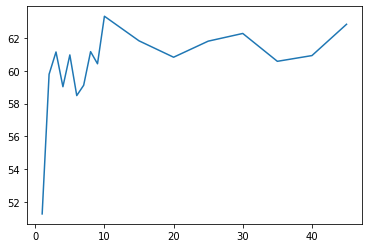

In [163]:
acc = []
nodes = []

for test_nodes in np.arange(1, 10):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
for test_nodes in np.arange(10, 50, 5):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
plt.plot(nodes, acc)